<a href="https://colab.research.google.com/github/Albina1310/Albina1310/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%90_%D0%92_%D1%82%D0%B5%D1%81%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ А/В теста

**Задача — провести оценку результатов A/B-теста и оценить корректность проведения теста и проанализировать его результаты.** В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**План работы**:

*Откроем файлы, помотрим их и сделаем предобработку*:
- Преобразование данных к нужным типам

*Проверим корректность проведения теста*:
- Соответствие данных условиям ТЗ
- Проверим время на проведения теста одновременно с маркетинговыми акциями
- посмотрим равномерность распределения пользователей по группам и тестам

*Исследовательский анализ данных*:
- Распределение пользователей по дня в группах
- Распределение событий на одного пользователя в выборках
- Распределение событий и пользователей по дням
- Изменение конверсии в воронке на разных этапах

*A/B - тестирование*:
- Проверка статистической разницы долей z-критерием

*Вывод*

## Откроем файлы, посмотрим их и сделаем предобработку

In [49]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st
from statsmodels.stats.weightstats import ztest as ztest
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters
import math as mth
import warnings

warnings.filterwarnings('ignore')

try:
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    prodject_marceting = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
except:
    events = pd.read_csv('final_ab_events.csv')
    prodject_marceting = pd.read_csv('ab_project_marketing_events.csv')
    new_users = pd.read_csv('final_ab_new_users.csv')
    participants = pd.read_csv('final_ab_participants.csv')

In [50]:
display(events.head(), prodject_marceting.head(), new_users.head(), participants.head())

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [51]:
print(events.info())
print()
print(prodject_marceting.info())
print()
print(new_users.info())
print()
print(participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0  

In [52]:
# проверяем на количество пропусков и дубликатов
print(f'Количество пропусков в events:\n{events.isna().sum()}')
print()
print(f'Количество пропусков в prodject_marceting:\n{prodject_marceting.isna().sum()}')
print()
print(f'Количество пропусков в new_users:\n{new_users.isna().sum()}')
print()
print(f'Количество пропусков в participants:\n{participants.isna().sum()}')
print()
print(f'Количество дубликатов в events: {events.duplicated().sum()}')
print()
print(f'Количество дубликатов в prodject_marceting: {prodject_marceting.duplicated().sum()}')
print()
print(f'Количество дубликатов в new_users: {new_users.duplicated().sum()}')
print()
print(f'Количество дубликатов в participants: {participants.duplicated().sum()}')


Количество пропусков в events:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Количество пропусков в prodject_marceting:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Количество пропусков в new_users:
user_id       0
first_date    0
region        0
device        0
dtype: int64

Количество пропусков в participants:
user_id    0
group      0
ab_test    0
dtype: int64

Количество дубликатов в events: 0

Количество дубликатов в prodject_marceting: 0

Количество дубликатов в new_users: 0

Количество дубликатов в participants: 0


In [53]:
# посмотрим уникальные значения в таблицах и их количество
print('Уникальные названия событий в events', events['event_name'].unique())
print()
print('Всего уникальных пользователей в events:', events['user_id'].nunique())
print()
print('Всего уникальных названий промо-акций в prodject_marceting:', prodject_marceting['name'].nunique())
print()
print('Уникальные названия регионов в prodject_marceting:', prodject_marceting['regions'].unique())
print()
print('Всего уникальных пользователей в new_users:', new_users['user_id'].nunique())
print()
print('Уникальные названия регионов в new_users:', new_users['region'].unique())
print()
print('Уникальные названия девайсов в new_users:', new_users['device'].unique())
print()
print('Всего уникальных пользователей в participants:', participants['user_id'].nunique())
print()
print('Уникальные названия групп в participants:', participants['group'].unique())
print()
print('Уникальные названия тестов в participants:', participants['ab_test'].unique())

Уникальные названия событий в events ['purchase' 'product_cart' 'product_page' 'login']

Всего уникальных пользователей в events: 58703

Всего уникальных названий промо-акций в prodject_marceting: 14

Уникальные названия регионов в prodject_marceting: ['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'
 'EU, CIS, APAC' 'CIS']

Всего уникальных пользователей в new_users: 61733

Уникальные названия регионов в new_users: ['EU' 'N.America' 'APAC' 'CIS']

Уникальные названия девайсов в new_users: ['PC' 'Android' 'iPhone' 'Mac']

Всего уникальных пользователей в participants: 16666

Уникальные названия групп в participants: ['A' 'B']

Уникальные названия тестов в participants: ['recommender_system_test' 'interface_eu_test']


In [54]:
# посмотрим столбец events['details'], причину пропусков
events.groupby('event_name').count()

,user_id,event_dt,details
event_name,,,
login,189552,189552,0
product_cart,62462,62462,0
product_page,125563,125563,0
purchase,62740,62740,62740


In [55]:
# поменяем типы данных в столбцах с датой
events['event_dt'] = pd.to_datetime(events['event_dt'])
prodject_marceting['start_dt'] =  pd.to_datetime(prodject_marceting['start_dt'])
prodject_marceting['finish_dt'] = pd.to_datetime(prodject_marceting['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

**Вывод:** Открыв 4 файла и посмотрев всю информацию о них, мы увидели:
- пропуски в столбце "details" - данные есть лишь в строках с наименованием события "purchase" и это значит, что информация в столбце с детализацией предназначалась только для получения информации о продаже услуг - их стоимости. Данные **пропуски не ошибка, заполнять не нужно**.
- дубликатов в данных не обнаружено.
- тип данных о дате стоят в типе "object" - соответственно мы поменяли на нужный тип "datetime".
- обнаружили 4 события, по которым мы в дальнейшем построим воронку и измерим метрики: 'purchase', 'product_cart', 'product_page', 'login'.
- всего уникальных пользователей совершивших события 58703
- новых пользователей 61733
- маркетинговых акций всего 14 проводилось
- рекламные акции осуществлялись в 6 регионах
- новые пользователи пришли из 4 регионов
- участников тестов 16666
- группы две: А -контрольная, В-новая
- тестов 2: 'recommender_system_test' 'interface_eu_test'

С данными все впорядке. Далее проверим соответствие данных проводимого теста Техническому Заданию

## Проверим корректность проведения теста


### Соответствие данных условиям ТЗ

In [56]:
# посмотрим дату начала и окончания запуска новых пользователей
print('Дата начала запуска новых пользователей', new_users['first_date'].min())
print('Дата окончания запуска новых пользователей', new_users['first_date'].max())

Дата начала запуска новых пользователей 2020-12-07 00:00:00
Дата окончания запуска новых пользователей 2020-12-23 00:00:00


In [57]:
# посмотрим даты начала событий и окончания
print ('Начало событий произошло:', events['event_dt'].min())
print ('Конец событий произошло:',events['event_dt'].max())

Начало событий произошло: 2020-12-07 00:00:33
Конец событий произошло: 2020-12-30 23:36:33


In [58]:
# посмотрим сколько всего новых пользователей из EU
regoin_total_EU = new_users[new_users['region'] == 'EU']
print('Общее количество новых пользователей из Европы', regoin_total_EU['user_id'].count())

Общее количество новых пользователей из Европы 46270


In [59]:
# посмотрим сколько пользователей находятся в нужном нам тесте из EU
regoin_new_users_EU = new_users[new_users['user_id'].isin(participants.query('ab_test == "recommender_system_test"')['user_id'])]
regoin_new_users_EU['region'].value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

In [60]:
regoin_new_users_EU = regoin_new_users_EU[regoin_new_users_EU['region'] == 'EU']
print('Количество пользователей, участвующих в нашем тесте из Европы', regoin_new_users_EU['user_id'].count())

Количество пользователей, участвующих в нашем тесте из Европы 6351


In [61]:
# найдем процент пользователей из EU в тесте recommender_system_test от общего числа
print('Процент пользователей из EU в тесте recommender_system_test от общего числа',
      round(regoin_new_users_EU['user_id'].count()/regoin_total_EU['user_id'].count()*100, 2))

Процент пользователей из EU в тесте recommender_system_test от общего числа 13.73


In [62]:
# посмотрим сколько пользователей в каждом тесте
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Пока на данном этапе мы можем сопоставить имеющиеся данные с ТЗ и видим следующее:
- есть нужный нам тест - recommender_system_test - название совпадает с ТЗ
- есть две группы: А и В - совпадает с ТЗ
- дата запуска: 2020-12-07 - совпадает с ТЗ
- **дата остановки набора новых пользователей: 2020-12-23 - отклонение по ТЗ- мы уберем с данных лишние 2 дня, чтобы соответствовать требованиям до 2020-12-21**
- **дата остановки: 2020-12-30, а должно быть 2021-01-04 - нарушение теста, что соответственно может повлиять на весь анализ и метрики**
- **аудитория - 13.73%, а должно быть 15% из EU - отклонение от ТЗ - после изменения даты набора новых пользователей проверим еще раз на соответствие данное условие**
- ожидаемое количество участников теста: 6701 - что соответствует ТЗ, но мы еще раз это условие перепроверим после изменения даты


In [63]:
# срежем данные по дате до 21 декабря
new_users = new_users[new_users['first_date'] <= "2020-12-21 00:00:00"]
print('Изменили дату по условию ТЗ на:', new_users['first_date'].max())

Изменили дату по условию ТЗ на: 2020-12-21 00:00:00


In [64]:
# сохраним только тех пользователей, что участвовали в тесте recommender_system_test и пришли из Европы
recommender_system_test = new_users[new_users['user_id'].isin(participants.query('ab_test == "recommender_system_test"')['user_id'])]
recommender_system_test = recommender_system_test.query('region == "EU"')

In [65]:
# проверяем даты начала и окончания набора новых пользователей
print('Дата начала запуска новых пользователей', recommender_system_test['first_date'].min())
print('Дата окончания запуска новых пользователей', recommender_system_test['first_date'].max())

Дата начала запуска новых пользователей 2020-12-07 00:00:00
Дата окончания запуска новых пользователей 2020-12-21 00:00:00


In [66]:
print('Процент пользователей из EU участвующих в нашем тесте:', recommender_system_test['user_id'].count()/
      new_users[new_users['region'] == 'EU']['user_id'].count()*100)

Процент пользователей из EU участвующих в нашем тесте: 15.0


In [67]:
print('Количество уникальных пользователей участвующих в тесте после среза даты:', recommender_system_test['user_id'].nunique())

Количество уникальных пользователей участвующих в тесте после среза даты: 6351


**Вывод**: По условиям ТЗ совпадают почти все требования:
- название теста, количество групп, дата начала проведения теста, дата остановки набора новых пользователей, количество пользователей участвующих в тесте и процент пользователей пользователей из EU

**кроме одного важного:**
- **тест остановлен 30.12.2020, а должно было быть 04.01.2021 - соответственно это нарушение приведет к искажению анализа и повлияет на исследуемые метрики.**

Далее посмотрим есть ли совпадения даты проведения теста вместе с проведением маркетинговых промо-акций.

### Проверим время проведения теста одновременно с маркетинговыми акциями

In [68]:
prodject_marceting.query('"2020-12-07" < start_dt < "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


**Вывод**: одновременно с тестом проводились 2 маркетинговые акции. Одна из которых была проведена в Европе, но дата начала акции 25 декабря, а набор пользователей закончился 21 декабря - соответственно сложно судить о влиянии акции на тест. Пользователи пришли не под влиянием акции, но находясь уже в группах могли увидеть эту акцию и совершить событие. Не зная какого рода была проведена рекламная компания - мы однозначного ответа о влиянии на совершение того или иного события говорить не можем. О данной акции нужно узнать подробнее у маркетологов. Тем не менее влияние на обе группы было одинаковым, если оно было таковым. **Также хотелось бы отметить, что тест проводился в преддверии новогодних праздников, что тоже могло сказаться на наш тест и поведение пользователей.**

### Посмотрим равномерность распределния пользователей по группам и по тестам, проверим на нарушения

In [69]:
# смотрим, присутствуют ли пользователи, входящие в оба теста сразу
print('Количестов пользователей участвующих в обеих тестах сразу:', participants['user_id'].duplicated().sum())

Количестов пользователей участвующих в обеих тестах сразу: 1602


In [70]:
# проверим присутствуют ли пользователи, входящие в обе группы А и В нашего теста
print('Количестов пользователей участвующих в обеих группах сразу внутри нашего теста:',
      participants.query('ab_test == "recommender_system_test"')['user_id'].duplicated().sum())

Количестов пользователей участвующих в обеих группах сразу внутри нашего теста: 0


Поскольку есть пользователи участвующие в 2-х тестах, но они не участвовали в двух группах одновременно нашего теста- получается эти пользователи участвовали в группах конкурируещего теста. Нам нужно понять как повлияли клиенты конкурируещего теста на наш тест.

In [71]:
# посмотрим сколько пользователей участвовали в конкурирующем тесте из нашего

test_1 = participants.query('ab_test == "recommender_system_test"').reset_index()
test_2 = participants.query('ab_test == "interface_eu_test" and group == "B"').reset_index()
user_total = test_1[test_1['user_id'].isin(test_2['user_id'])]
print('В нашем тесте они распределены слудующим образом:')
print(user_total['group'].value_counts())
print('Всего пользователей пересекающихся в тестах' ,user_total['user_id'].nunique())

В нашем тесте они распределены слудующим образом:
A    439
B    344
Name: group, dtype: int64
Всего пользователей пересекающихся в тестах 783


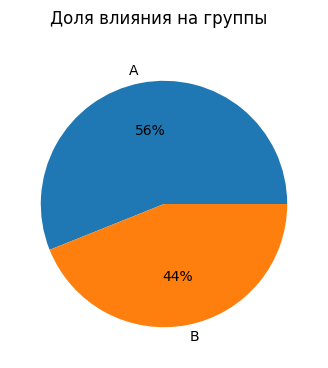

In [72]:
# визуально посмотрим равномерно ли распределены эти пользователи в нашем тесте
fig,(ax1) = plt.subplots(figsize=(4, 4))
fig.suptitle('Доля влияния на группы', fontsize=12)
ax1.pie(user_total['group'].value_counts(), labels=user_total['group'].value_counts().index, autopct='%.0f%%');

Видим, что пользователи из другого теста влияют на группы нашего
теста не равномерно - в группе А их на 12% больше. Лучше удалить этих пользователей, чтобы анализ был более корректным.

In [73]:
# удалим пользователей из нашего теста имеющих отношение к тесту конкурируеющего
user_total = test_1[test_1['user_id'].isin(test_2['user_id'])]['user_id']
recommender_system_test = recommender_system_test.query('user_id not in @user_total')
print('количество оставшихся пользователей в тесте', recommender_system_test['user_id'].nunique())

количество оставшихся пользователей в тесте 5568


In [74]:
# проверим показатель аудитории в 15% из Европы
print('Процент пользователей из EU участвующих в нашем тесте:', round(recommender_system_test['user_id'].count()/
      new_users[new_users['region'] == 'EU']['user_id'].count()*100))

Процент пользователей из EU участвующих в нашем тесте: 13


In [75]:
# объеденим таблицы и посмотрим распределение по группам в нашем тесте
control = pd.merge(recommender_system_test, participants.query('ab_test == "recommender_system_test"'), on='user_id', how='inner')
print(control['user_id'].nunique())

5568


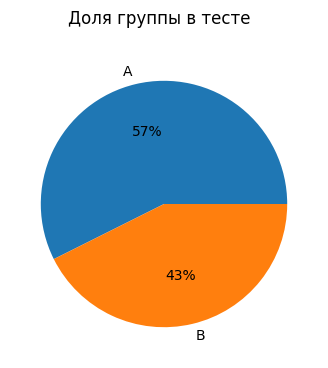

In [76]:
# посмотрим распределение по группам в нашем тесте
fig,(ax1) = plt.subplots(figsize=(4, 4))
fig.suptitle('Доля группы в тесте', fontsize=12)
ax1.pie(control.groupby('group')['user_id'].nunique(), labels=control.groupby('group')['user_id'].nunique().index, autopct='%.0f%%');

Количество пользователей совершивших хоть одно событие равно 3050



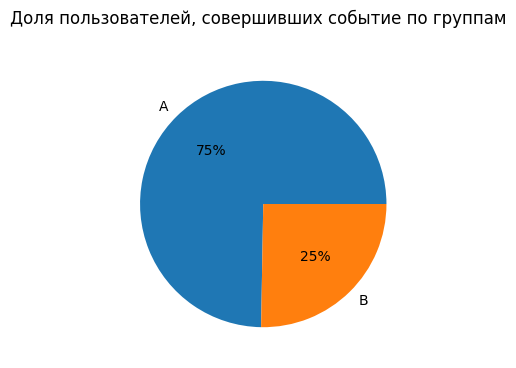

In [77]:
# посмотрим сколько пользователей совершивших хоть одно событие и распредление их по группам
event = events.merge(control, how='left', on='user_id').dropna(axis='index', how='any',subset=['group'])
print('Количество пользователей совершивших хоть одно событие равно', event['user_id'].nunique())
print()
event.groupby('group')['user_id'].nunique()

# посмотрим распределение по группам в нашем тесте
fig,(ax1) = plt.subplots(figsize=(4, 4))
fig.suptitle('Доля пользователей, совершивших событие по группам', fontsize=12)
ax1.pie(event.groupby('group')['user_id'].nunique(), labels=event.groupby('group')['user_id'].nunique().index, autopct='%.0f%%');

In [78]:
# посмотрим на участников нашего теста не сделавших ни одного события - NAN
event_NAN = control.merge(events, how='left', on='user_id')
event_NAN = event_NAN[event_NAN['event_name'].isna()]
print('Количество уникальынх пользователей с пустыми значениями в событиях', event_NAN['user_id'].nunique())
print()
print('Распределение их по группам:')
print(event_NAN.groupby('group')['user_id'].count())
print()
print('Процент пользоватлей из группы "В" =', round(event_NAN.query('group == "B"')['user_id'].count()/event_NAN['user_id'].count()*100))
print()
print('Распределение по дате регистрации:')
print(event_NAN.groupby('first_date')['user_id'].count())
print()
print('Доля от общего числа участников с нулевым событием =', round(event_NAN['user_id'].count()/control['user_id'].count()*100))

Количество уникальынх пользователей с пустыми значениями в событиях 2518

Распределение их по группам:
group
A     916
B    1602
Name: user_id, dtype: int64

Процент пользоватлей из группы "В" = 64

Распределение по дате регистрации:
first_date
2020-12-07    245
2020-12-08    171
2020-12-09     75
2020-12-10    242
2020-12-11    139
2020-12-12    314
2020-12-13    434
2020-12-14    169
2020-12-15     95
2020-12-16     16
2020-12-17     89
2020-12-18    105
2020-12-19    120
2020-12-20    129
2020-12-21    175
Name: user_id, dtype: int64

Доля от общего числа участников с нулевым событием = 45


**Вывод**: Мы нашли, что есть 1602 пользователя участвующих в 2-х теста и в 2-х группах. Пользователи из конкурирующего теста, которые оказывают влияние на наш тест - 783. Они не равномерно распределены в нашей группе. Таких пользователей в группе "А" нашего теста больше на 12%. Чтобы не исказить последующий анализ - мы их удалили. Также ранее были удалены пользователи пришедшие позже 21 декабря по ТЗ, также убрали пользователей из других регионов, кроме EU - как требовалось по ТЗ. После всех срезов и удаления участников из конкурирующего теста - в нашем тесте осталось 5568 пользователей - нарушение условий ТЗ (должно быть 6000), также аудитория EU в нашем тесте стало меньше - всего 13% вместо 15% - тоже отклонение по ТЗ. Также распределение по группам в нашем тесте не равномерное - в группе "А" больше пользователей на 14% - это грубое нарушение проведения теста. Еще больше усугубляет положение проведенного теста - это большая разница в количестве пользователей совершивших хоть одно событие: в группе "А" на 50% больше пользователей.

**Итог по разделу:** Тест проводился не корректно:
- есть пересечения пользователей между двумя тестами, которые были убраны
- тест проводился одновременно с маркетинговой акцией, которая могла повлиять на пользователей нашего теста на совершение тех или иных событий. Поскольку акция началась 23 декабря - после завершения набора нами в тест пользователей, то данное нарушение условий можем не брать во внимание
- после удалений и срезов в нашем тесте осталось лишь 5568 пользователей, меньше 6000 необходимых - тоже нарушение условий ТЗ
- участники теста распределены по группам не равномерно, группа "А" больше по числу пользователей на 14% - это грубое нарушение проведения теста. Такое распределение может быть вследствии сбоя в системе распределения.
- число пользователей прошедших регистрацию различается: 75% в "А" против 25% в "В" - данный факт говорит о провале проведения теста в целом
- аудитория EU в нашем тесте составила 13%, вместо 15% необходимых - отклонение по ТЗ
- дата остановки: 2020-12-30 (последие действия были в эту дату), а должно быть 2021-01-04 - нарушение теста, что соответственно может повлиять на весь анализ и метрики.

**Также хочется отметить что участников теста без событий составляет 45% от общего числа - это почти половина. Больше таких пользователей из группы "В" - 64%. Регистрировались такие пользователи каждый день, особенно выделяются даты 7, 10, 12 и 13 декабря.**

## Исследовательский анализ

### посмотрим распределение пользователей по дням в каждой группе

In [79]:
# соеденим таблицы
control = control.merge(events, how='left', on='user_id')
print(control['user_id'].nunique())

5568


In [80]:
# посмотрим как распределялись все зарегистрированные пользователи по дням
registration = control.groupby(['first_date','group'], as_index=False)['user_id'].nunique().rename(columns={'user_id':'user_count'})

In [81]:
# визуализируем
fig = px.bar(registration, x='first_date', y='user_count', text='user_count', color='group')
fig.update_layout(title = 'Распределение всех зарегистрировавшихся пользователей по дням',
                  xaxis_title = 'Дни',
                  yaxis_title = 'Количество пользователей')
fig.show()

Распределние пользователей было не равномерным по группам, как ранее было нами выявлено. Также видим что в течении 2-х недель есть несколько пиков - всплеск регистраций: 7, 12-14 и 21 декабря. Можем предположить почему такие всплески - возможно это связано с днями недели и всплеск регистраций пользователей приходится на выходные. Не зная чем занимается компания и что мы тестируем, сложно еще что-то предположить.

### посмотрим распределение количества событий на одного человека в разрезе событий и групп

Чтобы сделать анализ условия: ожидаемый эффект за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

Мы исключим с событий те, что имеют пропуски и для каждого пользователя срежем данные по событию с 14 и более днями.

In [82]:
# сохраним из контрольной таблицы только тех пользоватлей которые совершили хоть одно событие
only_event = control.dropna(subset=['event_name'])
print(only_event['user_id'].nunique())

3050


In [83]:
only_event['data'] = only_event['event_dt'].dt.date
only_event['data'] = pd.to_datetime(only_event['data'])
only_event['data_14'] = only_event['data'] - only_event['first_date']
only_event = only_event[only_event['data_14'] <= pd.Timedelta(days=14)]

In [84]:
only_event

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,data,data_14
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,2020-12-07,0 days
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,2020-12-07,0 days
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,2020-12-07,0 days
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,2020-12-08,1 days
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN,2020-12-10,3 days
...,...,...,...,...,...,...,...,...,...,...,...
23076,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,product_page,NaN,2020-12-21,1 days
23077,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,NaN,2020-12-24,4 days
23078,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,NaN,2020-12-20,0 days
23079,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,NaN,2020-12-21,1 days


In [85]:
# создадим таблицу для подсчета количества событий на одного пользователя в каждой группе
users_events = only_event.groupby(['user_id', 'event_name'])['region'].count().reset_index()
users_events = users_events.rename(columns={'region':'events_count'})
users_events = users_events.merge(only_event[['user_id', 'group']], on='user_id').drop_duplicates()
users_events['user_id'].nunique()

3050

In [86]:
# таблица событий на одного пользователя по событиям и группам
users_events = users_events.groupby(['group', 'event_name'])['events_count'].sum().reset_index()
users_events.loc[users_events['group'] == 'A', 'event_by_one_user'] = round(users_events['events_count']/only_event.query('group == "A"')['user_id'].nunique(), 2)
users_events.loc[users_events['group'] == 'B', 'event_by_one_user'] = round(users_events['events_count']/only_event.query('group == "B"')['user_id'].nunique(), 2)
display(users_events)
print('Число пользователей совершивших событие в группе "А"', only_event.query('group == "A"')['user_id'].nunique())
print('Число пользователей совершивших событие в группе "В"', only_event.query('group == "B"')['user_id'].nunique())

,group,event_name,events_count,event_by_one_user
0,A,login,7018,3.08
1,A,product_cart,2114,0.93
2,A,product_page,4514,1.98
3,A,purchase,2205,0.97
4,B,login,2036,2.64
5,B,product_cart,542,0.70
6,B,product_page,1074,1.39
7,B,purchase,531,0.69


Число пользователей совершивших событие в группе "А" 2279
Число пользователей совершивших событие в группе "В" 771


In [87]:
# визуализируем
fig = px.bar(users_events, y='event_by_one_user', x= 'event_name', text='event_by_one_user', color = 'group', barmode='group')
fig.update_layout(title = 'Количество событий на одного пользователя по событиям и группам',
                  yaxis_title = 'события',
                  xaxis_title = 'Количество')
fig.show()

На одного пользователя наибольшее число событий в "login", так же видим что горуппа "А" по всем событиям опережает группу "В"

### посмотрим распределние количества событий в группах по дням

In [88]:
# преобразуем event_dt к дате без времени
only_event['event_data'] = only_event['event_dt'].dt.date

In [89]:
# создадим таблицу с распределением количества событий по дням
event_group_date = only_event.groupby(['event_data', 'group'])['user_id'].count().reset_index()
event_group_date = event_group_date.rename(columns={'user_id':'events_count'})


In [90]:
# визуализируем
fig = px.bar(event_group_date, y='events_count', x= 'event_data', color = 'group', barmode='group')
fig.update_layout(title = 'Количество событий на одного пользователя по событиям и группам',
                  yaxis_title = 'Количество',
                  xaxis_title = 'Дата')
fig.show()

Как и ранее было выявлено, количество событий в группе "В" маленькое из-за низкого количества пользователей совершивших хоть одно событие в ней. Также видим всплеск событий с 14 декабря по 21 декабря у группы "А". Далее идет убывание по количеству событий с 22 декабря. В то время как у группы "В" распределение событий по дням более равномерно. В начале количество событий груп более равны, начиная с 14 дня резко возрастает у группы "А". Это обусловлено, тем что клиенты после включения их в группу "В" перестали совершать события - активных пользователей в группе в несколько раз меньше - всего 771. Также нужно отметить, что нет событий с 30 декабря.

### Посмотрим как меняется конверсия в воронке в выборках на разных этапах

Посчитаем общее количество действий совершенных всем интересующими нас пользователями вне зависимости от группы

In [91]:
only_event.groupby('event_name')['user_id'].count().sort_values()

event_name
product_cart    2656
purchase        2736
product_page    5588
login           9054
Name: user_id, dtype: int64

Итого мы имеем 4 типа действий: login - логин, product_page - переход на страницу с товарами, purchase - оплата,  product_cart - переход на страницу с корзиной. По логике оплата должна быть последним целевым действием для пользователя. Это нужно учитывать при построении воронки.

На данном этапе можно заметить, что в меню покупки переходили чаще чем в меню корзины. Видимо сервис позволяет совершать действия не линейно и пользователь может оформить товар минуя переход в корзину.

In [92]:
# подготовим данные для создания воронки
funnel_A = only_event.query('group == "A"').groupby(['event_name', 'group']).agg({'user_id':'nunique'}).reset_index()
funnel_B = only_event.query('group == "B"').groupby(['event_name', 'group']).agg({'user_id':'nunique'}).reset_index()
funnel_A = funnel_A.rename(columns = {'user_id': 'event_count'})
funnel_B = funnel_B.rename(columns = {'user_id': 'event_count'})

# Сортировка DataFrame по порядку событий
funnel_A = funnel_A.sort_values('event_count', ascending=False)
funnel_B = funnel_B.sort_values('event_count', ascending=False)

Мы получили датафрейм с колчеством совершивщих определенное действие уникальными пользователями. Единственное, что при агрегировании порядок действий выстроен не в том порядке. Исправим это.

In [93]:
new_index = [0, 2, 1, 3]
funnel_A = funnel_A.reindex(new_index)
funnel_B = funnel_B.reindex(new_index)
funnel_A['share'] = round(100*(funnel_A['event_count']/funnel_A['event_count'][0]))
funnel_A['conversion'] = 0
for i in range(0, len(funnel_A['event_count'])):
    if i == 0:
        funnel_A['conversion'].iloc[i] = 100
    else:
        funnel_A['conversion'].iloc[i] = round((funnel_A['event_count'].iloc[i] / funnel_A['event_count'].iloc[i-1]), 2)*100
display(funnel_A)

funnel_B['share'] = round(100*(funnel_B['event_count']/funnel_B['event_count'][0]))
funnel_B['conversion'] = 0
for i in range(0, len(funnel_B['event_count'])):
    if i == 0:
        funnel_B['conversion'].iloc[i] = 100
    else:
        funnel_B['conversion'].iloc[i] = round((funnel_B['event_count'].iloc[i] / funnel_B['event_count'].iloc[i-1]), 2)*100
display(funnel_B)

,event_name,group,event_count,share,conversion
0,login,A,2279,100.0,100
2,product_page,A,1476,65.0,65
1,product_cart,A,686,30.0,46
3,purchase,A,734,32.0,107


,event_name,group,event_count,share,conversion
0,login,B,770,100.0,100.0
2,product_page,B,429,56.0,56.0
1,product_cart,B,214,28.0,50.0
3,purchase,B,219,28.0,102.0


In [94]:
# объеденим таблицы и сделаем по ней воронку - график
funnel = pd.concat([funnel_A, funnel_B])
funnel

,event_name,group,event_count,share,conversion
0,login,A,2279,100.0,100.0
2,product_page,A,1476,65.0,65.0
1,product_cart,A,686,30.0,46.0
3,purchase,A,734,32.0,107.0
0,login,B,770,100.0,100.0
2,product_page,B,429,56.0,56.0
1,product_cart,B,214,28.0,50.0
3,purchase,B,219,28.0,102.0


In [95]:
groups = ['A', 'B']
fig = go.Figure()
for i, group in enumerate(groups):
    fig.add_trace(go.Funnel(
        name = group,
        y = (funnel[(funnel['group'] == group)]['event_name']),
        x = (funnel[(funnel['group'] == group)]['event_count']),
        textposition = "inside",
        textinfo = "value+percent initial+percent previous",
        constraintext='outside',
        #textangle = 90,
        insidetextfont = {'color': 'black'}))
fig.update_layout(title="Воронка событий пользователей в группах", width=1000, height=800,
                  yaxis_title = 'События')
fig.show()

Как видим по воронке, процент доходящих до покупки в группе"А" выше на 4%. Поэтому говорить о улучшении метрики не менее, чем на 10% мы не можем. Здесь прослеживается ухудшение показателя в воронке продаж группы "В". К просмотру карточки в группе "А" больше доходят пользователей чем в группе "В".

**Прежде чем приступить к А\В тестированию, нужно учесть следующие особенности данных:**
- соответствие данных требованиям Технического Задания: дата начала и конца теста, дата окончания включения пользователей в тест, количество участников теста, аудиторию, количество тестов и групп и соответствия названиям и другие возможные условия согласно ТЗ
- необходимо проверить пересечения пользователей, то есть возможного их участия одновременно в нескольких тестах-группах
- необходимо проверить на равномерность распределния данных между группами в тесте
- учесть возможное влияния еще каких-либо данных на проведение теста(рекламные компании, праздичные дни, сезонность, события внутри компании, внешние события).

## Проверим статистическую разницу долей z-критерием.

Проведем сравнение пропорций метрик с помощью **z-критерия**.

**Нулевая гипотеза:** между долями нет значимой разницы.(равны доли)

**Альтернативная:** между долями есть значимая разница.(не равны доли)

Критический уровень значимости (альфа): будем рассчитывать с помощью *поправки Бонферрони*, так как мы будем проводить множественные тесты на одинаковом наборе данных (без сбора новых наблюдений).

Поскольку число пользователей в событии login совпадает с общим числом пользователей, то на нем проводить тест не будем.

Выберем альфа равное 0.05, а с поправкой alpha = 0.05 / 3 = 0.016

alpha = 0.016

In [96]:
# сделаем таблицу
group_event = only_event.pivot_table(index = 'group', columns = 'event_name', values = 'user_id', aggfunc='nunique')
group_event['total'] = only_event.groupby('group')['user_id'].nunique()
group_event

event_name,login,product_cart,product_page,purchase,total
group,,,,,
A,2279,686,1476,734,2279
B,770,214,429,219,771


In [97]:
# функция для проведения Z-теста
def test_z (event, event1, total, total1, alpha = 0.016):
    p1 = event/total
    p2 = event1/total1
    p_combined = (event + event1) / (total + total1)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total + 1/total1)) # ваш код

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).')

In [98]:
# проведем тест для события product_cart в группах "A" и "B"
test_z(group_event['product_cart']['A'], group_event['product_cart']['B'], group_event['total']['A'], group_event['total']['B'])

p-значение:  0.21721122664962245
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [99]:
# проведем тест для события product_page в группах "A" и "B"
test_z(group_event['product_page']['A'], group_event['product_page']['B'], group_event['total']['A'], group_event['total']['B'])

p-значение:  6.120730626113513e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [100]:
# проведем тест для события purchase в группах "A" и "B"
test_z(group_event['purchase']['A'], group_event['purchase']['B'], group_event['total']['A'], group_event['total']['B'])

p-значение:  0.048942596376941205
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


**Вывод:** Отвергнуть нулевую гипотезу не получилось, т.е. доли в воронке продаж между группами "А" и "В" равны в событиях  product_cart (просмотр карзины) и purchase (покупки). А в событии product_page (просмотр карточки) статистическая разница есть и она значимая.

Можем считать проведение теста провальным: за 14 дней с момента регистрации пользователи не показали улучшения каждой метрики не менее, чем на 10%. По всем показателям группа "А" выигрывает.

## Общий вывод

Мы осмотрели и проанализировали полученные данные и пришли к следующим выводам:

-- были допущены множественные нарушения:
* дата остановки 30 декабря, вместо 4 января
* дата конца набора новых пользователей 23 декабря, вместо 21 декабря
* 783 пользователя нашего теста участвовали в конкурирующем тесте
* во время проведения теста была проведена маркетинговая акция, также нужно учесть и время проведения - приближающиеся новогодние праздничные дни
* пользователи не равномерно были распределены по группам внутри нашего теста: 57% против 43% участников теста
* участников теста сначало было достаточно - 6700, но после фильтрации и удалений не корретных данных их стало - 5568
* в дальнейшем сделав анализ обнаружили, что пользователей сделавших регистрацию было вдвое меньше 3050 вместо 6000 и распределение этих пользователей по группам было грубо нарушено: 75% в группе "А" и 25% в группе "В"
* пользователей из Европы было достаточно -15% в начале анализа, но далее их количество уменьшилось - нарушив требование ТЗ.

-- распределение пользователей по дням было не равномерным между группами, вероятно это сбой в системе распределения

-- по количеству событий на одного пользователя между группами лидирует группа "А" по всем событиям

-- в распределении количества событий по дням увидели значительный всплеск в группе "А" с 14 по 21 декабря, затем идет снижение числа событий

-- в конверсии и по воронке продаж увидели выигравшую по метрикам группу "А". Доля пользователей дошедших до покупки выше на 4% в ней.

-- статистически значимая разница в долях между группами в событии - просмотр карточки - выигрывает группа "А"

Таким образом по метрикам выигрывает и становится лучшей группа "А". Но поскольку были большие нарушения, множественные нарушения проведения теста, мы однозначно можем сказать - тест провальный и проведен не верно, соответственно доверять его результатам не стоит.

**Рекомендуется:** подготовить данные заново, провериь их целостность и соответствие ТЗ и провести тестирование повторно.

